In [23]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

## a)

In [24]:
#We create a new object-class for IBVP
class BVP(object): 
    def __init__(self, x_a=0, x_b=1, y_a=0, y_b=1, ux_0=0, ux_1=0, uy_0=0, uy_1=0, RHS=0):
        
        self.ux_0 = ux_0       # left boundary condition
        self.ux_1 = ux_1       # right boundary condition
        self.uy_0 = uy_0       # Upper boundary condition
        self.uy_1 = uy_1       # Lower boundary condition
        
        self.x_a = x_a         # left side boundry for x
        self.y_a = y_a         # left side boundry for y
        self.x_b = x_b         # right side boundry for x
        self.y_b = y_b         # right side boundry for y
        
        self.RHS = RHS        # right hand side of equation
        

In [25]:
#Reuse code from lecture notes
#Plotting function 
def plot_solution(x, y, U, txt='Solution'):
    
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={"projection": "3d"})
    Y, X = np.meshgrid(x,y)
    ax.plot_wireframe(X, Y, U)
    ax.plot_surface(X,Y, U, cmap='hot')
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('Y')
    plt.ylabel('x')
    plt.title(txt);

In [26]:
#Initial condition

def ux_0(x,y):      #Y=0
    return np.sin(np.pi*x)*np.sin(np.pi*y)
    
def ux_1(x,y):      #Y=1
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def uy_0(x,y):      #X=0
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def uy_1(x,y):      #X=1
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def RHS(x,y,a):     # Right hand side
    return -(np.pi**2*a*1*np.cos(np.pi*x)*np.cos(np.pi*y)-np.pi**2*(a+1)*np.sin(np.pi*x)*np.sin(np.pi*y)-np.pi**2*1**2*np.sin(np.pi*x)*np.sin(np.pi*y))


def analyticSol(x,y): 
    return x**2*np.cos(5*y)

def analyticN(x,y): #Y=1
    return analyticSol(x,y)

def analyticS(x,y): #Y=0
    return analyticSol(x,y)

def analyticE(x,y): #X=1
    return analyticSol(x,y)

def analyticW(x,y): #X=0
    return analyticSol(x,y)

def RHS_2(x,y,a): #Right hand side
    r=1
    return -(2*(a+1)*np.cos(5*y) - 20*r*x*np.sin(5*y) - 25*r**2*x**2*np.cos(5*y))

In [27]:
#Reuse code from lecture notes

def grid(BVP,M,N): 
        
    x = np.linspace(BVP.x_a, BVP.x_b, M+1,endpoint=True)
    y = np.linspace(BVP.y_a, BVP.y_b, N+1,endpoint=True)
    
    # these ones are valid only for this case
    # in general the radius of the smallest inscribed
    # circle should be taken
    h=x[1]-x[0] # x typical space-step
    k=y[1]-y[0] # y typical space-step
    
    # full coorindate array of INTERNAL points
    shape = [len(x[1:-1]), len(y[1:-1])]
    x, y = np.meshgrid(x[1:-1], y[1:-1])

    # reshaping so that I have columnwise vectors
    # with all the x and y coordinates. In practice, THIS passage already
    # re-order the array in a vector that follows the numbering explained
    # in the figure above
    x, y = x.flatten(), y.flatten()
    
    # array with coordinates
    coord = np.zeros((x.size,2))
    coord[:,0]=x
    coord[:,1]=y
    
    
    return h, k, coord, shape

In [28]:
#Define a function that creates a tridiagonal matrix
def tridiag(a,h,k, N, M):    
    
    A = np.zeros(((N-2)*(M-2), (N-2)*(M-2)))        #Define an 2D array we can create our matrix in
    x = np.ones((N-2)*(M-2))                        #Define an 1D array with same length as our matrix with only ones
     
    x_L=np.copy(x[1:])                              #Slice the array to fit the lower diagonal
    x_L[M-3::M-2]=0                                 #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_LL=np.copy(x[:-(M-1)])                        #Slice the array to fit the m-1 lower diagonal
    x_LL[M-3::M-2]=0                                #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_U=np.copy(x[1:])                              #Slice the array to fit the upper diagonal                   
    x_U[M-3::M-2]=0                                 #Remove every M-2 element to create adjust for the boundry gridpoints
    
    x_UU=np.copy(x[:-(M-1)])                        #Slice the array to fit the m-1 upper diagonal
    x_UU[M-3::M-2]=0                                #Remove every M-2 element to create adjust for the boundry gridpoints
    
    r=np.sqrt(k/h)
    #Use np.diag to create the A matrix
    A=np.diag(x*(2*a/h**2+2/(h**2)),0) + np.diag(x_U*(-a)/h**2,1) + np.diag(x_L*(-a)/h**2,-1) + np.diag(x_UU*(-1)/(h**2),(M-1)) + np.diag(x_LL*(-1)/(h**2),(-M+1))
    return A

In [35]:
def solver(BVP, a, M=10, N=10):
    # Input: 
    #       IBVP: object with the initial and boundary values and right hand side 
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.
    h,k,coord,shape = grid(BVP,M,N)
    U=np.zeros((N+1,M+1))
    
    x_grid = np.linspace(BVP.x_a, BVP.x_b, M+1)
    y_grid = np.linspace(BVP.y_a, BVP.y_b, N+1)
    
    
    
    x_0_values=BVP.ux_0(x_grid,BVP.y_a)
    x_1_values=BVP.ux_1(x_grid,BVP.y_b)
    y_0_values=BVP.uy_0(BVP.x_a,y_grid)
    y_1_values=BVP.uy_1(BVP.x_b,y_grid)
    
    U[0,:]=x_0_values
    U[-1,:]=x_1_values
    
    U[:,0]=y_0_values
    U[:,-1]=y_1_values[::1]
    
    A=tridiag(a,h,k,N+1,M+1)
    #plt.spy(A)
    
    

    g_vec=np.zeros((M-1)*(N-1))
    
    for i in range(len(g_vec)):
        if(i%(M-1)==0):
            g_vec[i]+=-a*y_0_values[i//(M-1)+1]/(h**2) - y_0_values[i//(M-1)]/(h**2)
            
        elif((i+1)%(M-1)==0):
            g_vec[i]+=-a*y_1_values[i//(M-1)+1]/(h**2) - y_1_values[i//(M-1)+2]/(h**2)
        
        if(i>0 and i<(M-1)):
            g_vec[i]+=-x_0_values[i]/(h**2)
            
        elif((M-1)*(N-2) <= i <= (M-1)*(N-1)-2):
            g_vec[i]+=-x_1_values[i%(M-1)+2]/(h**2)
    

    f_vec=BVP.RHS(coord[:,0],coord[:,1],a)
    U_vec=np.linalg.solve(A,f_vec-g_vec)
    U_array = np.reshape(U_vec, (N-1, M-1))
    
    U[1:-1,1:-1]=U_array
    print(h,k)
    return U, x_grid, y_grid


0.025 0.025


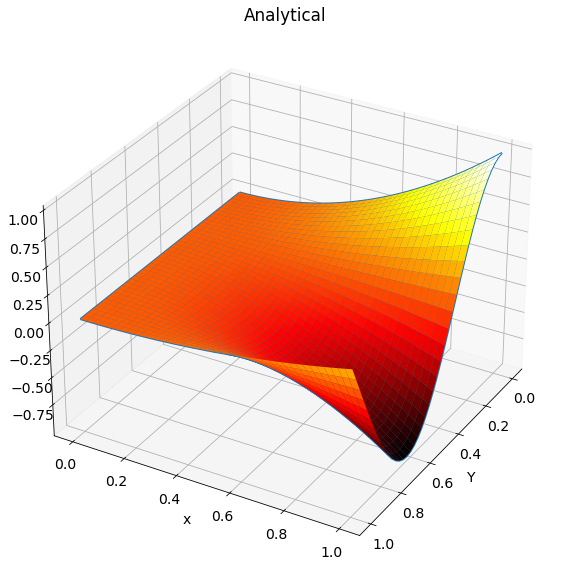

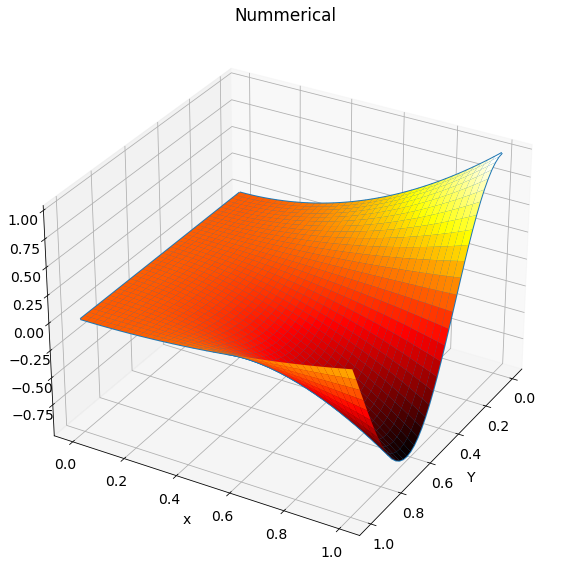

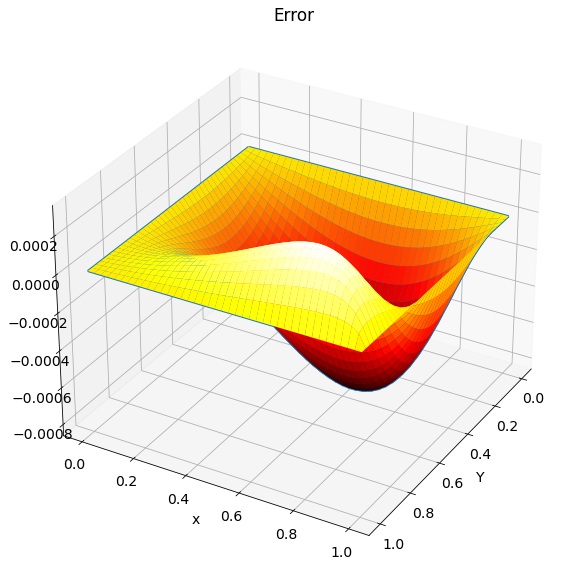

In [38]:
a=1
test_BVP=BVP(0, 1, 0, 1, ux_0, ux_1, uy_0, uy_1, RHS)
test_BVP_2=BVP(0, 1, 0, 1, analyticW,analyticN,analyticS,analyticE,RHS_2)


U, x_grid, y_grid=solver(test_BVP_2, a, M=40,N=40)
X, Y = np.meshgrid(x_grid,y_grid)

solution=analyticSol(X,Y)



plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U, "Nummerical")
plot_solution(x_grid,y_grid,(solution-U), "Error")

## c)

In [9]:
#Reuse convergence-tester from lecture-code 

def convergence_test_space(u_analytic, test_problem, solver=solver):
    a=2
    P = 5
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 5
    for p in range(P):
        U, x, y = solver(test_problem, a, M=M, N=M)
        X, Y = np.meshgrid(x,y)
        Eh = u_analytic(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order



In [10]:
H, E, p = convergence_test_space(analyticSol, test_BVP_2, solver)
#H, E, p = convergence_test_space(uy_1, test_BVP, solver)


import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H, 'Error': E ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.20000000,0.21394843,0.00000000
1,0.10000000,0.18597187,0.20217872
2,0.05000000,0.18254873,0.02680276
3,0.02500000,0.18152442,0.00811798
4,0.01250000,0.18121645,0.00244969


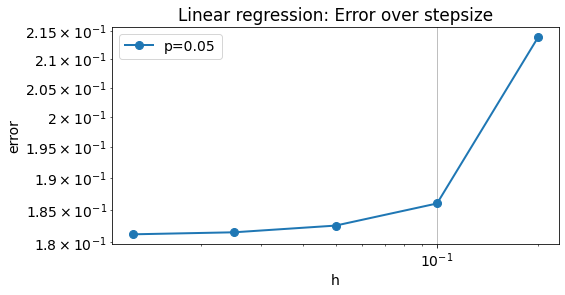

In [11]:
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();

## d)

We are asked to now investigate the problem with a bad direction. We want to solve the problem for an irrational $r$.
We want to solve this by using the fattening of the boundry. Since our new $r$ is irational, we can no longer adjust our upper boundry for y to be equal $1$. We are asked to define $h$ and $k$ the following way
$$
\begin{align*}
h&=\frac{1}{M} \\
k&=|r|h =\frac{1}{N}\\
\end{align*}
$$

We can combine this with our prior definitions to find the value for N
$$
\begin{align*}
N=&\frac{1}{|r|h} \\
\implies N=&\frac{M}{|r|}
\end{align*}
$$

Since $r$ is an irational number, we know that $N$ will be irational, which means we can only find an N such that we get arbitrary close to $y=1$, but never exactly $y=1$.


In [12]:
def analyticSol_d(x,y): 
    return x**2*np.cos(5*y)

def analyticN_d(x,y): #Y=1
    return analyticSol(x,y)

def analyticS_d(x,y): #Y=0
    return analyticSol(x,y)

def analyticE_d(x,y): #X=1
    return analyticSol(x,y)

def analyticW_d(x,y): #X=0
    return analyticSol(x,y)

def RHS_d(x,y,a): #Right hand side
    r=1
    return -(2*(a+1)*np.cos(5*y) - 20*r*x*np.sin(5*y) - 25*r**2*x**2*np.cos(5*y))

In [13]:
def solver_d(BVP, a,r, M=10):
    # Input: 
    #       IBVP: object with the initial and boundary values and right hand side 
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.
    
    N=int(np.ceil(M/np.abs(r)))
    BVP.y_b=np.abs(r)*(1/M)*N
    
    h,k,coord,shape = grid(BVP,M,N)
    U=np.zeros((N+1,M+1))
    
    x_grid = np.linspace(BVP.x_a, BVP.x_b, M+1)
    y_grid = np.linspace(BVP.y_a, BVP.y_b, N+1)
    
    x_0_values=BVP.ux_0(x_grid,BVP.y_a)
    x_1_values=BVP.ux_1(x_grid,BVP.y_b)
    y_0_values=BVP.uy_0(BVP.x_a,y_grid)
    y_1_values=BVP.uy_1(BVP.x_b,y_grid)
    x_1_values_mod=BVP.ux_1(x_grid,1)
    
    U[0,:]=x_0_values
    U[-1,:]=x_1_values_mod
    
    U[:,0]=y_0_values
    U[:,-1]=y_1_values[::1]
    
    A=tridiag(a,h,k,N+1,M+1)
    #plt.spy(A)
    
    

    g_vec=np.zeros((M-1)*(N-1))
    
    for i in range(len(g_vec)):
        if(i%(M-1)==0):
            g_vec[i]+=-a*y_0_values[i//(M-1)+1] - y_0_values[i//(M-1)]
            
        elif((i+1)%(M-1)==0):
            g_vec[i]+=-a*y_1_values[i//(M-1)+1] - y_1_values[i//(M-1)+2] 
        
        if(i>0 and i<(M-1)):
            g_vec[i]+=-x_0_values[i]
            
        elif((M-1)*(N-2) <= i <= (M-1)*(N-1)-2):
            g_vec[i]+=-x_1_values[i%(M-1)+2]
    

    f_vec=BVP.RHS(coord[:,0],coord[:,1],a)
    U_vec=np.linalg.solve(A,f_vec-g_vec/(h**2))
    U_array = np.reshape(U_vec, (N-1, M-1))
    
    U[1:-1,1:-1]=U_array
    
    y_grid[-1]=1
    
    return U, x_grid, y_grid


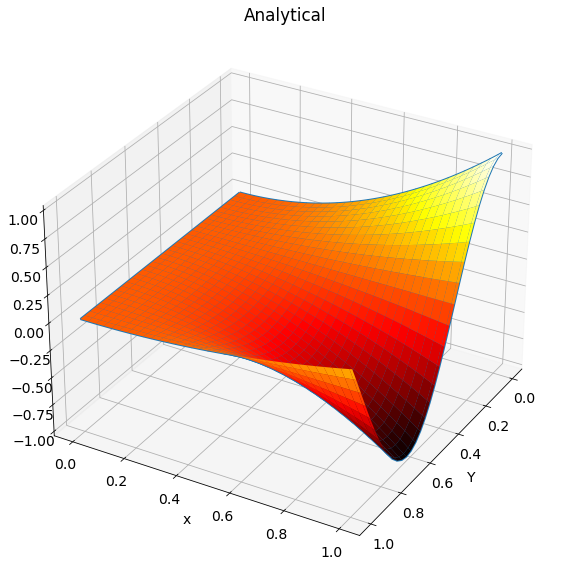

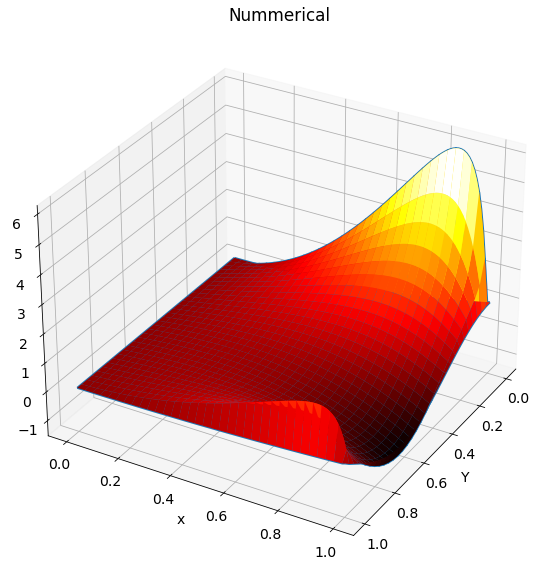

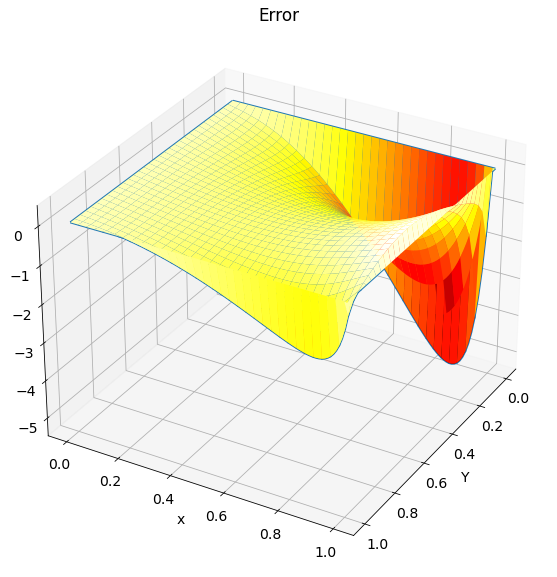

In [14]:
a=2
r=np.pi

test_BVP_d=BVP(0, 1, 0, 1, analyticN_d,analyticS_d,analyticW_d,analyticE_d,RHS_d)
U_d, x_grid, y_grid = solver_d(test_BVP_d, a, r, M=100)

X, Y = np.meshgrid(x_grid,y_grid)
solution=analyticSol_d(X,Y)



plot_solution(x_grid,y_grid,solution, "Analytical")
plot_solution(x_grid,y_grid,U_d, "Nummerical")
plot_solution(x_grid,y_grid,(solution-U_d), "Error")